In [97]:
# -- coding=utf-8 --
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.colors as colors
from matplotlib.backends.backend_pdf import PdfPages
# from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
#                                   AnnotationBbox)
import regionmask
import geopandas
import pandas as pd
#import maskout
import math
import warnings
%matplotlib inline

maskout http://bbs.06climate.com/forum.php?mod=viewthread&tid=89530

smooth https://stackoverflow.com/questions/14765891/image-smoothing-in-python
平滑以后值就会变

[matplotlib 3D scatterplot with marker color corresponding to RGB values](https://stackoverflow.com/questions/29399248/matplotlib-3d-scatterplot-with-marker-color-corresponding-to-rgb-values)

In [2]:
def latlon_grid(bmap, lon_int, lat_int, labels='lb', **kwargs):
    '''Draws a lat-lon grid in an easy way.

    Some default values are taken from rcParams instead of 'black' (color) and
    1.0 (linewidth) which is the default in Basemap.

    In Basemap, the label pad is computed in projection units. Now you can use
    the keyword argument 'labelpad' to control this separation in points. If
    not specified then this value is taken from rcParams.

    Arguments:

    bmap -- Basemap object.
    lon_int, lat_int -- Difference in degrees from one longitude or latitude to
                        the next.
    labels -- String specifying which margins will be used to write the labels.
              If None, no label will be shown.
              It is assummed that left/right margins (i.e. Y axes) correspond
              to latitudes and top/bottom (X axes) to longitudes. It is valid
              every combination of the characters 't' | 'b' | 'l' | 'r'
              (top|bottom|left|right).
              Ex: 'lrb' means that the longitude values will appear in bottom
              margin and latitudes in left and right.
    **kwargs -- Other arguments to drawparallels, drawmeridians and plt.text.
                labelpad has units of points.
    '''
    # Proccesses arguments and rcParams for defult values
    if 'color' not in kwargs:
        kwargs['color'] = plt.rcParams['grid.color']
    if 'linewidth' not in kwargs:
        kwargs['linewidth'] = plt.rcParams['grid.linewidth']
    if 'labelpad' in kwargs:
        padx = pady = kwargs['labelpad']
        del kwargs['labelpad']
    else:
        pady = plt.rcParams['xtick.major.pad']
        padx = plt.rcParams['ytick.major.pad']
    if 'size' in kwargs:
        xfontsize = yfontsize = kwargs['size']
        del kwargs['size']
    elif 'fontsize' in kwargs:
        xfontsize = yfontsize = kwargs['fontsize']
        del kwargs['fontsize']
    else:
        xfontsize = plt.rcParams['xtick.labelsize']
        yfontsize = plt.rcParams['ytick.labelsize']
    # Vectors of coordinates
    lon0 = bmap.lonmin // lon_int * lon_int
    lat0 = bmap.latmin // lat_int * lat_int
    lon1 = bmap.lonmax // lon_int * lon_int
    lat1 = bmap.latmax // lat_int * lat_int
    nlons = (lon1 - lon0) / lon_int + 1
    nlats = (lat1 - lat0) / lat_int + 1
    assert nlons / int(nlons) == 1, nlons
    assert nlats / int(nlats) == 1, nlats
    lons = np.linspace(lon0, lon1, int(nlons))
    lats = np.linspace(lat0, lat1, int(nlats))
    # If not specified then computes de label offset by 'labelpad'
    xos = yos = None
    if 'xoffset' in kwargs:
        xos = kwargs['xoffset']
    if 'yoffset' in kwargs:
        yos = kwargs['yoffset']
    if xos is None and yos is None:
        # Page size in inches and axes limits
        fig_w, fig_h = plt.gcf().get_size_inches()
        points = plt.gca().get_position().get_points()
        x1, y1 = tuple(points[0])
        x2, y2 = tuple(points[1])
        # Width and height of axes in points
        w = (x2 - x1) * fig_w * 72
        h = (y2 - y1) * fig_h * 72
        # If the aspect relation is fixed then compute the real values
        if bmap.fix_aspect:
            aspect = bmap.aspect * w / h
            if aspect > 1:
                w = h / bmap.aspect
            elif aspect < 1:
                h = w * bmap.aspect
        # Offset in projection units (meters or degrees)
        xos = padx * (bmap.urcrnrx - bmap.llcrnrx) / w
        yos = pady * (bmap.urcrnry - bmap.llcrnry) / h
    # Set the labels
    latlabels = [False] * 4
    lonlabels = [False] * 4
    if labels is not None:
        pst = {'l': 0, 'r': 1, 't': 2, 'b': 3}
        lst = {'l': latlabels, 'r': latlabels, 't': lonlabels, 'b': lonlabels}
        for i in labels.lower():
            lst[i][pst[i]] = True
    # Draws the grid
    bmap.drawparallels(lats, labels=latlabels, fontsize=yfontsize,
                       xoffset=xos, yoffset=yos, **kwargs)
    bmap.drawmeridians(lons, labels=lonlabels, fontsize=xfontsize,
                       xoffset=xos, yoffset=yos, **kwargs)

In [3]:
def plot_rec(bmap, lower_left, upper_left, lower_right, upper_right):
    xs = [lower_left[0], upper_left[0],
          upper_right[0],lower_right[0],lower_left[0]]
    ys = [lower_left[1], upper_left[1],
          upper_right[1],lower_right[1],lower_left[1]]
    bmap.plot(xs, ys, color="r",latlon = True)

In [4]:
def fill_maxwell(ax):
        Nlignes=300
        Ncol=300
        img = np.zeros((Nlignes,Ncol,4))
        dx = 2.0/(Ncol-1)
        dy = 1.0/(Nlignes-1)
        for i in range(Ncol-1):
            for j in range(Nlignes-1):
                x = -1.0+i*dx
                y = j*dy
                v = y
                r = (x+1-v)/2.0
                b = 1.0-v-r
                if (r>=0) and (r<=1.0) and (v>=0) and (v<=1.0) and (b>=0) and (b<=1.0):
                    r,v,b = 1/max(r,v,b)*r,1/max(r,v,b)*v,1/max(r,v,b)*b
                    img[j][i] = np.array([r,v,b,1.0])
                else:
                    img[j][i] = np.array([1.0,1.0,1.0,0.0])
        a = 1.0/math.sqrt(3)
        fig = ax.imshow(img,origin='lower',extent=[-a,a,0.0,1.0])
        # ax.plot([0,a/2.,-a/2.,0],[0,0.5,0.5,0],'w--',linewidth=2,)
        # ax.annotate("", xy=( a/2.,0.5), xytext=( -a ,0.),  arrowprops=dict(arrowstyle="->"))
        # ax.annotate("", xy=(-a/2.,0.5), xytext=( a,0.),   arrowprops=dict(arrowstyle="->"))
        # ax.annotate("", xy=( 0,1.),     xytext=( 0,0.),  color='white', arrowprops=dict(arrowstyle="->"))
        # ax.annotate("", xy=( a ,0.),    xytext=( -a/2.,0.5) ,color='white',arrowprops=dict(arrowstyle="->"))
        # ax.annotate("", xy=(-a,0.),     xytext=( a/2.,0.5) ,color='white',arrowprops=dict(arrowstyle="->"))
        # ax.annotate("", xy=( 0,0.),     xytext=( 0,1.),     arrowprops=dict(arrowstyle="->"))        
        # #         
        # ax.plot([0,a/2.],[1/3.,0.5],'w--',linewidth=2,)
        # ax.plot([0,-a/2.],[1/3.,0.5],'w--',linewidth=2,)
        # ax.plot([0,0.],[1/3.,0.],'w--',linewidth=2,)  
        fsize = 10      
        plt.text(-0.78, -0.15, "$\Delta{Tair}$", fontsize=fsize, color='k',weight='bold') #,rotation=30
        plt.text( 0.38, -0.15, "$\Delta{DF}$", fontsize=fsize, color='k',weight='bold')  ## ,rotation=-30
        plt.text( -0.15,  1.05, "$\Delta{VPD}$", fontsize=fsize, color='k',weight='bold')

        # ax.text(  a/2.+0.05,0.6, "Tair\n-100%"   , fontsize=fsize, color='w',rotation=30)
        # ax.text( -a/2-0.3,0.6, "DF\n-100%"   , fontsize=fsize, color='w',rotation=-30)
        # ax.text( -0.1,  -0.2, " VPD\n-100%", fontsize=fsize, color='w')
                        
        ax.axis('off')
        return fig

In [109]:
def regfig(lat,lon,data,z_min=0.,z_max=1.5,figname="regcmfig",title=None,units=None):
    fig = plt.figure()
    ax = fig.add_axes([0.1,0.1,0.85,0.85]) 
    #m = Basemap(projection='lcc', \
    #            area_thresh=1000.,rsphere=(6378137.00,6356752.3142),\
    #            width=5640000,height=4140000,\
    #            lat_0=36.,lon_0=107.,lat_1=25.,lat_2=50., ax=ax)
    m = Basemap(projection='lcc',
       resolution='i',
       lat_0=32.,lon_0=118., width=4E6, height=4E6)

    # m.fillcontinents(color='gray',lake_color='aqua')
    #m.drawmapboundary(fill_color='dimgray')  #dimgray
    xi, yi = m(lon, lat)
    #cs = m.imshow(data,interpolation='nearest')
    cs=m.scatter(xi, yi, c=data,s=200)
    #clip = maskout.shp2clip(cs,ax,m,'D:\data\map\cnhimap',"China",vcplot = True)
    # cs = m.pcolor(xi, yi, np.squeeze(data), cmap="rainbow",vmin=z_min, vmax=z_max)
    # cs = m.pcolor(xi, yi, np.squeeze(data),norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03,
    #                                           vmin=z_min, vmax=z_max), cmap="coolwarm")
    # bounds = np.linspace(z_min, z_max, 20)
    # norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    # cs = m.pcolor(xi, yi, np.squeeze(data), cmap="coolwarm",norm=norm)  ### Pcolor with a log scale
    latlon_grid(m, 10, 5, labels='lb', labelpad=10, linewidth=0.) #dashes=[1, 3]
    # parallels = np.arange(0.,60,5.)
    # m.drawparallels(parallels, color='k', linewidth=.01,
    #  zorder=0, dashes=[1, 1], labels=[1,0,0,0], fmt='%g') # , fontsize=10
    # meridians = np.arange(80.,180.,10.)
    # m.drawmeridians(meridians, color='k', linewidth=1.0,
    #  zorder=0, dashes=[1, 1], labels=[0,0,0,1], fmt='%g') # , fontsize=10
    #  
    llcrnrlon =  100.
    urcrnrlon =  122.
    llcrnrlat =  21.
    urcrnrlat =  40.
    lower_left = (llcrnrlon, llcrnrlat)
    lower_right= (urcrnrlon, llcrnrlat)
    upper_left = (llcrnrlon, urcrnrlat)
    upper_right= (urcrnrlon, urcrnrlat)
    # plot_rec(m, lower_left, upper_left, lower_right, upper_right)
    # m.readshapefile('coastline_withoutchina','whatevername',color='black')
    # # m.readshapefile('cnmap/cnmap','whatevername',color='black')
    # # m.readshapefile('country1','whatevername',color='black')
    # m.readshapefile('cnmap/chinaprov','whatevername',color='black')
    
    # cbar_num_format = "%0.1f"
    # cbar = m.colorbar(cs, pad="5%", format=cbar_num_format)
    # cbar = m.colorbar(cs, location='bottom', pad="10%", format=cbar_num_format)
    # if(units): cbar.set_label(units)
    # if(title): plt.title(title)
    if(title): fig.text(0.15, 0.9, title,fontsize="larger",color="white") #,weight='bold')
    # if(title): fig.text(0.8, 0.25, title,fontsize="large")
    # plt.show()
    left, bottom, width, height = 0.77, 0.19, 0.14, 0.14
    ax2 = fig.add_axes([left, bottom, width, height])
    fig2 = fill_maxwell(ax2)
    left, bottom, width, height = 0.17, 0.18, 0.15, 0.15
    ax3 = fig.add_axes([left, bottom, width, height])
    #fig3 = piefig(ax3,fracs)    
    # plt.savefig(figname, dpi=300)
    with PdfPages(figname+'.pdf') as pdf:
        pdf.savefig(fig,bbox_inches='tight',pad_inches = 0.05 )    

In [51]:
meteo_file = "yrd_mrl.csv"

In [52]:
df= pd.read_csv(meteo_file)

In [53]:
df.head()

,FA1,FA2,FA3,D,lat,lon
0,58.365529,122.407816,-55.277364,1030.090351,29.0,120.0
1,90.582464,200.654243,-228.522608,1422.111940,31.0,121.0
2,12.214751,-18.760236,26.745564,1164.041063,31.5,119.5
3,-91.303410,-31.795600,57.252510,1102.020513,32.0,119.0
4,183.315573,33.324871,58.550866,931.477893,32.0,118.0


In [54]:
# 获取每个变量的值
lons = df['lon']
lats = df['lat']
fa1 = df['FA1']
fa2 = df['FA2']
fa3 = df['FA3']

In [71]:
max((abs(fa1).max(),abs(fa2).max(),abs(fa3).max()))

460.11164110000004

In [74]:
cgpp = np.c_[abs(fa1),abs(fa2),abs(fa3)]   ### par: red; vpd: green; temp: blue
cgpp  = abs(cgpp)/max((abs(fa1).max(),abs(fa2).max(),abs(fa3).max()))

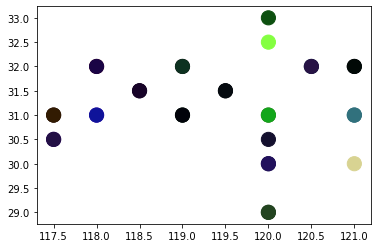

In [76]:
fig, ax = plt.subplots()
ax.scatter(lons, lats, s=200, facecolors=cgpp)
plt.show()

In [91]:
lats=np.array(lats)

In [93]:
lons=np.array(lons)

In [106]:
lats

array([29. , 31. , 31.5, 32. , 32. , 31.5, 31. , 30. , 32. , 31. , 30.5,
       31. , 31. , 32. , 29. , 31. , 31.5, 32. , 32. , 31.5, 31. , 30. ,
       32. , 31. , 30.5, 31. , 31. , 32. , 33. , 30.5, 30. , 32.5])

In [107]:
lons

array([120. , 121. , 119.5, 119. , 118. , 118.5, 117.5, 120. , 121. ,
       119. , 117.5, 118. , 120. , 120.5, 120. , 121. , 119.5, 119. ,
       118. , 118.5, 117.5, 120. , 121. , 119. , 117.5, 118. , 120. ,
       120.5, 120. , 120. , 121. , 120. ])

C:\Users\xigrug\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  """


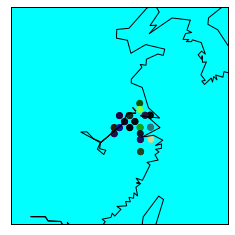

In [117]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

map = Basemap(projection='lcc', 
              lat_0=32, lon_0=118, width=2E6, height=2E6)

map.drawmapboundary(fill_color='aqua')
#map.fillcontinents(color='coral',lake_color='aqua')
map.drawcoastlines()


x, y = map(lons, lats)

map.scatter(x, y,marker='o',color=cgpp)

plt.show()

In [77]:
fracsgpp = [0.5,0.3,0.2]

C:\Users\xigrug\Anaconda3\Anaconda\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # Remove the CWD from sys.path while we load stuff.


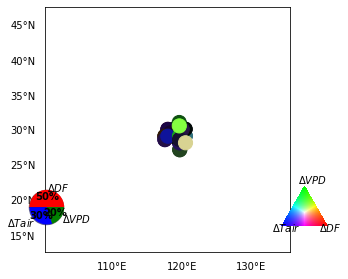

In [110]:
regfig(lats,lons,cgpp, fracsgpp,z_min=-1.,z_max=1.,figname="ccn",units=None,title="")